In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
#import torch.utils.tensorboard as tb
from Preprocessing.preprocessing import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd
from Postprocessing.postprocessing import PostProcessing

In [2]:
#static parameters
train_batch_size = 170
val_batch_size = 170
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [3]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [4]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [5]:
#network_output

In [6]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [7]:
'''
data is highly unbalanced
# '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [8]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -117]
network_output = network_output[: -117]

print(network_input.shape)
print(network_output.shape)

torch.Size([8500, 50, 1])
torch.Size([8500])


In [9]:
# x = (network_input.view(-1)).cpu().numpy()
# sns.distplot(x)

In [54]:
# Bakchodi Normalization
network_input=network_input.cpu().numpy().tolist()
for i in range(len(network_input)):
    for j in range(len(network_input[i])):
        network_input[i][j][0]=((network_input[i][j][0])*(max_midi_number-min_midi_number)+min_midi_number)/max_midi_number
network_input=torch.Tensor(network_input).cuda()

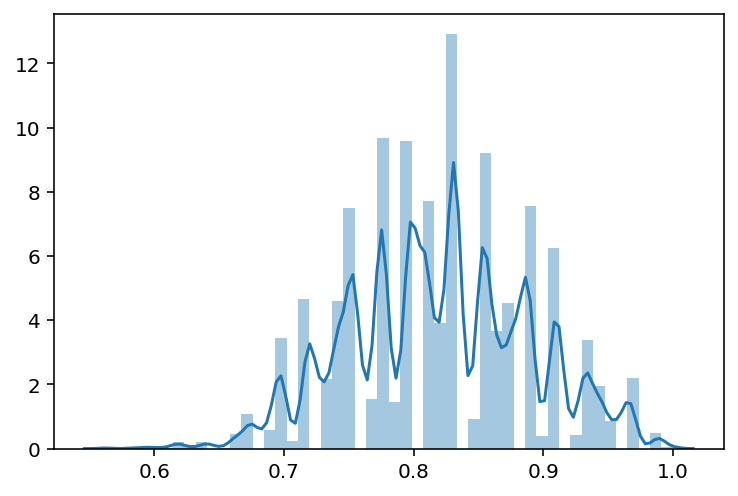

In [40]:
x = (network_input.view(-1)).cpu().numpy()
sns.distplot(x)

In [65]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        #output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight) 

In [66]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [67]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [68]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [69]:
epochs = 700
min_val_loss = np.Inf

validation_loss_list = []
training_loss_list = []
validation_accuracy_list = []
training_accuracy_list = []


for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output = model.forward(inputs, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        #logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        output = model.forward(inputs, val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    
    training_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(val_accuracy)
    training_loss_list.append(train_loss)
    validation_loss_list.append(val_loss)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256-38-fasdfa.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.4031786 	Val Loss:3.0497272 	Train Acc: 7.235294% 	Val Acc: 11.4117651%
Validation Loss decreased from    inf to 3.049727, saving the model weights
Epoch: 1	Train Loss: 3.1691780 	Val Loss:2.9660709 	Train Acc: 8.235294% 	Val Acc: 11.4117651%
Validation Loss decreased from 3.049727 to 2.966071, saving the model weights
Epoch: 2	Train Loss: 3.1263971 	Val Loss:2.9541180 	Train Acc: 8.558824% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.966071 to 2.954118, saving the model weights
Epoch: 3	Train Loss: 3.1002797 	Val Loss:2.9499761 	Train Acc: 9.102941% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.954118 to 2.949976, saving the model weights
Epoch: 4	Train Loss: 3.0904256 	Val Loss:2.9463727 	Train Acc: 9.647059% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.949976 to 2.946373, saving the model weights
Epoch: 5	Train Loss: 3.0814796 	Val Loss:2.9418081 	Train Acc: 9.07353% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.946373 to 

Epoch: 59	Train Loss: 2.6396005 	Val Loss:2.5851869 	Train Acc: 15.72059% 	Val Acc: 14.2352945%
Epoch: 60	Train Loss: 2.6305355 	Val Loss:2.5409527 	Train Acc: 16.33824% 	Val Acc: 13.5882356%
Validation Loss decreased from 2.579539 to 2.540953, saving the model weights
Epoch: 61	Train Loss: 2.6032565 	Val Loss:2.5235650 	Train Acc: 15.91177% 	Val Acc: 13.3529414%
Validation Loss decreased from 2.540953 to 2.523565, saving the model weights
Epoch: 62	Train Loss: 2.5815313 	Val Loss:2.5306399 	Train Acc: 16.39706% 	Val Acc: 14.0000004%
Epoch: 63	Train Loss: 2.5789875 	Val Loss:2.5060994 	Train Acc: 15.76471% 	Val Acc: 14.5882356%
Validation Loss decreased from 2.523565 to 2.506099, saving the model weights
Epoch: 64	Train Loss: 2.5664588 	Val Loss:2.4888059 	Train Acc: 15.70588% 	Val Acc: 15.3529415%
Validation Loss decreased from 2.506099 to 2.488806, saving the model weights
Epoch: 65	Train Loss: 2.5475680 	Val Loss:2.4808894 	Train Acc: 16.29412% 	Val Acc: 15.4705887%
Validation Loss 

Epoch: 118	Train Loss: 2.3312363 	Val Loss:2.3054621 	Train Acc: 22.38235% 	Val Acc: 22.8823535%
Validation Loss decreased from 2.313548 to 2.305462, saving the model weights
Epoch: 119	Train Loss: 2.3277202 	Val Loss:2.3189741 	Train Acc: 21.69118% 	Val Acc: 22.1176477%
Epoch: 120	Train Loss: 2.3588287 	Val Loss:2.3320789 	Train Acc: 22.23529% 	Val Acc: 22.7647063%
Epoch: 121	Train Loss: 2.3419606 	Val Loss:2.3075332 	Train Acc: 22.26471% 	Val Acc: 22.7058829%
Epoch: 122	Train Loss: 2.3348936 	Val Loss:2.3080584 	Train Acc: 22.33824% 	Val Acc: 21.5294124%
Epoch: 123	Train Loss: 2.3252831 	Val Loss:2.3324849 	Train Acc: 22.41177% 	Val Acc: 22.3529413%
Epoch: 124	Train Loss: 2.3482943 	Val Loss:2.3009547 	Train Acc: 22.01471% 	Val Acc: 21.7647064%
Validation Loss decreased from 2.305462 to 2.300955, saving the model weights
Epoch: 125	Train Loss: 2.3236083 	Val Loss:2.3110041 	Train Acc: 22.45588% 	Val Acc: 22.2352949%
Epoch: 126	Train Loss: 2.3151391 	Val Loss:2.3009300 	Train Acc: 22.

Epoch: 185	Train Loss: 2.2815080 	Val Loss:2.2495483 	Train Acc: 24.30882% 	Val Acc: 23.4705886%
Epoch: 186	Train Loss: 2.2835441 	Val Loss:2.2863788 	Train Acc: 24.11765% 	Val Acc: 22.8823535%
Epoch: 187	Train Loss: 2.2390134 	Val Loss:2.2095663 	Train Acc: 26.11765% 	Val Acc: 25.3529420%
Epoch: 188	Train Loss: 2.1905171 	Val Loss:2.1775860 	Train Acc: 26.41177% 	Val Acc: 26.6470598%
Epoch: 189	Train Loss: 2.2030249 	Val Loss:2.2613975 	Train Acc: 26.08824% 	Val Acc: 22.2352946%
Epoch: 190	Train Loss: 2.2034646 	Val Loss:2.1929658 	Train Acc: 27.0% 	Val Acc: 26.7058834%
Epoch: 191	Train Loss: 2.1807433 	Val Loss:2.2450029 	Train Acc: 27.36765% 	Val Acc: 23.4117654%
Epoch: 192	Train Loss: 2.1796530 	Val Loss:2.2577557 	Train Acc: 27.33824% 	Val Acc: 22.9411770%
Epoch: 193	Train Loss: 2.1710181 	Val Loss:2.1799942 	Train Acc: 28.22059% 	Val Acc: 26.4705890%
Epoch: 194	Train Loss: 2.1612203 	Val Loss:2.1719768 	Train Acc: 28.55882% 	Val Acc: 26.6470598%
Epoch: 195	Train Loss: 2.1868260 	

Epoch: 259	Train Loss: 2.0040014 	Val Loss:1.9755338 	Train Acc: 34.20588% 	Val Acc: 35.6470597%
Epoch: 260	Train Loss: 2.0209585 	Val Loss:2.0496800 	Train Acc: 34.2353% 	Val Acc: 32.4117658%
Epoch: 261	Train Loss: 1.9856220 	Val Loss:1.9525333 	Train Acc: 34.60294% 	Val Acc: 37.4705890%
Validation Loss decreased from 1.960792 to 1.952533, saving the model weights
Epoch: 262	Train Loss: 1.9799844 	Val Loss:1.9934867 	Train Acc: 34.9853% 	Val Acc: 34.2941186%
Epoch: 263	Train Loss: 1.9779767 	Val Loss:2.0067104 	Train Acc: 34.83824% 	Val Acc: 32.7058834%
Epoch: 264	Train Loss: 1.9816203 	Val Loss:1.9874608 	Train Acc: 35.07353% 	Val Acc: 35.9411776%
Epoch: 265	Train Loss: 1.9696332 	Val Loss:2.0077620 	Train Acc: 34.55882% 	Val Acc: 33.4117657%
Epoch: 266	Train Loss: 1.9486237 	Val Loss:2.0295736 	Train Acc: 36.02941% 	Val Acc: 33.5882363%
Epoch: 267	Train Loss: 1.9534708 	Val Loss:2.1022706 	Train Acc: 35.92647% 	Val Acc: 30.5882360%
Epoch: 268	Train Loss: 1.9573579 	Val Loss:2.021036

Epoch: 331	Train Loss: 1.7253882 	Val Loss:1.6970713 	Train Acc: 43.67647% 	Val Acc: 46.0000008%
Epoch: 332	Train Loss: 1.7038956 	Val Loss:1.6820405 	Train Acc: 43.73529% 	Val Acc: 46.4705887%
Epoch: 333	Train Loss: 1.7076831 	Val Loss:1.7225096 	Train Acc: 44.73529% 	Val Acc: 47.1764708%
Epoch: 334	Train Loss: 1.6765559 	Val Loss:1.6639046 	Train Acc: 45.45588% 	Val Acc: 46.6470593%
Epoch: 335	Train Loss: 1.6451627 	Val Loss:1.6930739 	Train Acc: 45.95588% 	Val Acc: 47.8235301%
Epoch: 336	Train Loss: 1.6400373 	Val Loss:1.6320267 	Train Acc: 47.25% 	Val Acc: 48.5882363%
Epoch: 337	Train Loss: 1.6820085 	Val Loss:1.6649176 	Train Acc: 45.48529% 	Val Acc: 48.1764713%
Epoch: 338	Train Loss: 1.6502131 	Val Loss:1.6732153 	Train Acc: 46.41177% 	Val Acc: 47.6470593%
Epoch: 339	Train Loss: 1.6607917 	Val Loss:1.6532855 	Train Acc: 46.16177% 	Val Acc: 47.8823531%
Epoch: 340	Train Loss: 1.6167861 	Val Loss:1.7184628 	Train Acc: 47.33824% 	Val Acc: 45.4117653%
Epoch: 341	Train Loss: 1.6384065 

Epoch: 403	Train Loss: 1.2058059 	Val Loss:1.1012295 	Train Acc: 61.64706% 	Val Acc: 68.0588245%
Epoch: 404	Train Loss: 1.2145628 	Val Loss:1.0771700 	Train Acc: 60.69118% 	Val Acc: 68.8235295%
Epoch: 405	Train Loss: 1.2323466 	Val Loss:1.1121270 	Train Acc: 59.98529% 	Val Acc: 66.6470593%
Epoch: 406	Train Loss: 1.2015171 	Val Loss:1.0450091 	Train Acc: 62.08824% 	Val Acc: 70.5294120%
Validation Loss decreased from 1.062772 to 1.045009, saving the model weights
Epoch: 407	Train Loss: 1.1856530 	Val Loss:1.0650008 	Train Acc: 61.29412% 	Val Acc: 68.8823533%
Epoch: 408	Train Loss: 1.1790504 	Val Loss:1.0284824 	Train Acc: 62.19118% 	Val Acc: 70.2941173%
Validation Loss decreased from 1.045009 to 1.028482, saving the model weights
Epoch: 409	Train Loss: 1.1927415 	Val Loss:1.0790307 	Train Acc: 61.60294% 	Val Acc: 67.7058834%
Epoch: 410	Train Loss: 1.1969871 	Val Loss:1.0879336 	Train Acc: 61.67647% 	Val Acc: 68.2352942%
Epoch: 411	Train Loss: 1.1946540 	Val Loss:1.0575324 	Train Acc: 61.

Epoch: 475	Train Loss: 0.7976337 	Val Loss:0.6113330 	Train Acc: 74.54412% 	Val Acc: 83.2941175%
Epoch: 476	Train Loss: 0.7933385 	Val Loss:0.6300034 	Train Acc: 75.19118% 	Val Acc: 82.2941172%
Epoch: 477	Train Loss: 0.8044695 	Val Loss:0.5653582 	Train Acc: 74.76471% 	Val Acc: 84.3529397%
Validation Loss decreased from 0.572194 to 0.565358, saving the model weights
Epoch: 478	Train Loss: 0.7738649 	Val Loss:0.5976668 	Train Acc: 76.16176% 	Val Acc: 83.6470580%
Epoch: 479	Train Loss: 0.7829774 	Val Loss:0.5386464 	Train Acc: 74.97059% 	Val Acc: 84.7058815%
Validation Loss decreased from 0.565358 to 0.538646, saving the model weights
Epoch: 480	Train Loss: 0.7685592 	Val Loss:0.5666917 	Train Acc: 75.45588% 	Val Acc: 84.3529409%
Epoch: 481	Train Loss: 0.7741668 	Val Loss:0.6527613 	Train Acc: 74.77941% 	Val Acc: 80.8235288%
Epoch: 482	Train Loss: 0.8070401 	Val Loss:0.6116845 	Train Acc: 74.22059% 	Val Acc: 82.9999995%
Epoch: 483	Train Loss: 0.7518680 	Val Loss:0.5715709 	Train Acc: 76.

Epoch: 549	Train Loss: 0.5848280 	Val Loss:0.4658424 	Train Acc: 81.11765% 	Val Acc: 86.6470587%
Epoch: 550	Train Loss: 0.5482678 	Val Loss:0.3408125 	Train Acc: 82.41176% 	Val Acc: 90.4117632%
Epoch: 551	Train Loss: 0.5067958 	Val Loss:0.3042957 	Train Acc: 84.36765% 	Val Acc: 91.9999993%
Epoch: 552	Train Loss: 0.4753074 	Val Loss:0.3866793 	Train Acc: 84.58823% 	Val Acc: 88.5294098%
Epoch: 553	Train Loss: 0.4666746 	Val Loss:0.3878109 	Train Acc: 85.29412% 	Val Acc: 89.1764700%
Epoch: 554	Train Loss: 0.5591739 	Val Loss:0.5145363 	Train Acc: 82.41176% 	Val Acc: 84.4705880%
Epoch: 555	Train Loss: 0.4748866 	Val Loss:0.3303742 	Train Acc: 84.51471% 	Val Acc: 91.5294105%
Epoch: 556	Train Loss: 0.5267741 	Val Loss:0.6230553 	Train Acc: 83.16176% 	Val Acc: 80.7058823%
Epoch: 557	Train Loss: 0.5279604 	Val Loss:0.3232924 	Train Acc: 83.19118% 	Val Acc: 91.1176467%
Epoch: 558	Train Loss: 0.4736891 	Val Loss:0.2303944 	Train Acc: 85.08823% 	Val Acc: 94.2352927%
Validation Loss decreased from

Epoch: 625	Train Loss: 0.3731289 	Val Loss:0.2042871 	Train Acc: 88.32353% 	Val Acc: 94.4705868%
Epoch: 626	Train Loss: 0.3504702 	Val Loss:0.1189885 	Train Acc: 89.39706% 	Val Acc: 97.0588231%
Epoch: 627	Train Loss: 0.2803357 	Val Loss:0.1122326 	Train Acc: 91.39706% 	Val Acc: 96.9411749%
Epoch: 628	Train Loss: 0.2519521 	Val Loss:0.0795361 	Train Acc: 92.41176% 	Val Acc: 98.2352924%
Validation Loss decreased from 0.102773 to 0.079536, saving the model weights
Epoch: 629	Train Loss: 0.2228344 	Val Loss:0.0939353 	Train Acc: 93.17647% 	Val Acc: 97.7058810%
Epoch: 630	Train Loss: 0.2118258 	Val Loss:0.0984837 	Train Acc: 93.63235% 	Val Acc: 97.3529398%
Epoch: 631	Train Loss: 0.2367060 	Val Loss:0.2145368 	Train Acc: 92.70588% 	Val Acc: 95.7058811%
Epoch: 632	Train Loss: 0.3126133 	Val Loss:0.2042836 	Train Acc: 90.44118% 	Val Acc: 95.1176453%
Epoch: 633	Train Loss: 0.2871824 	Val Loss:0.1398214 	Train Acc: 91.05882% 	Val Acc: 95.9999990%
Epoch: 634	Train Loss: 0.2501256 	Val Loss:0.1396

## MUSIC GENERATION

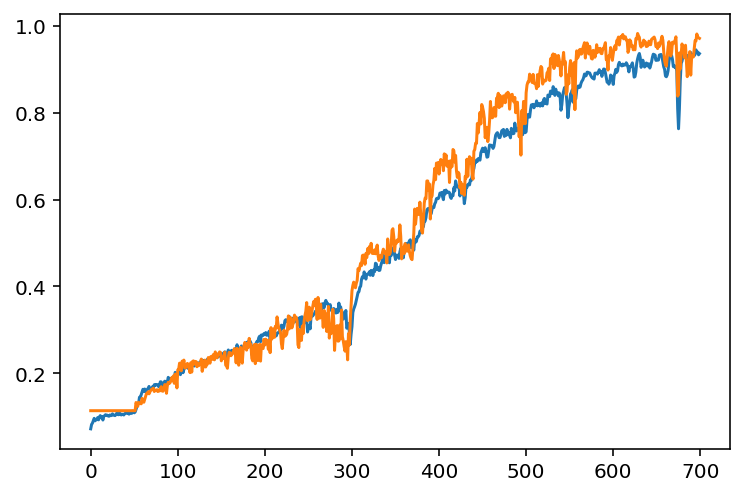

In [70]:
import matplotlib.pyplot as plt
plt.plot(training_accuracy_list)
plt.plot(validation_accuracy_list)

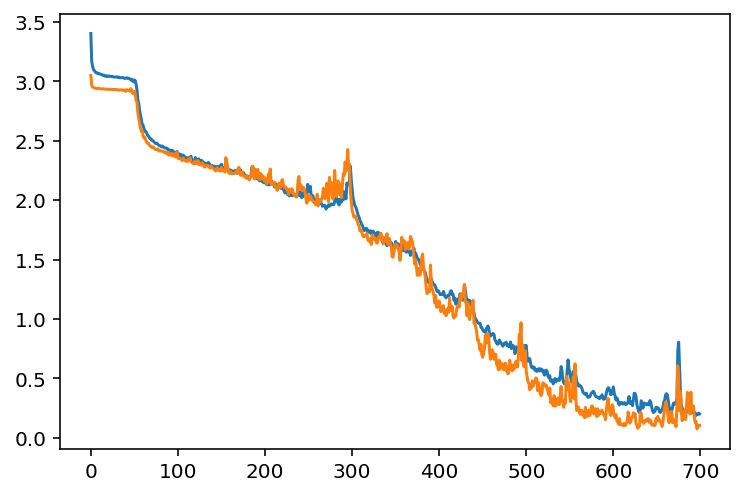

In [71]:
import matplotlib.pyplot as plt
plt.plot(training_loss_list)
plt.plot(validation_loss_list)

In [10]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256-38-bak_norm.pt'))
test_model.eval()
test_model.cuda()

NameError: name 'Stacked_LSTM' is not defined

In [ ]:
#load population database
#testing_data = np.ones(200)*1
testing_data = list(range(50,90))
testing_data.extend(testing_data[::-1])
testing_data_rev = testing_data[::-1]
testing_data_rev.extend(testing_data)
testing_data_rev.extend(testing_data_rev)
testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [ ]:
#abc

In [ ]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    #list1[i]=(list1[i]-50)/(89-50)
    list1[i]=(list1[i])/(89)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [ ]:
#testing_data

In [ ]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, min_note,test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
        
        test_output = test_model.forward(test_slice, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        
        #test_seq[0][sequence_length - 1 + i][0] = (int2note[top_class.item()] - min_note)/(max_note - min_note)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [ ]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number, min_midi_number)

In [ ]:
#predicted_notes_lst

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [ ]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

In [ ]:
PostProcessing().generate_midi_file('hello.midi', predicted_notes_lst)